# Regularisation ElasticNet regression
The following notebook contains pymc models for a Bayesian implementations lasso regression . The model is implemented in fantastic format within the Bayesreg package produced by Makalic & Schmidt (2016). Of which, is expertly explained within great review and methods tutorial paper by Van Erp, Oberski & Mulder (2019). Such a package is very helpful. However, for self pedagogy and modeliing flexibility impl

In [55]:
# Import relevant analysis packages.
import pymc as pm
import numpy as np 
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler

In [64]:
# Script functions

# Prediction mean squared error for Bayesian regularized regression model function
# 
def pmse_lm(ppc, ytest):
    # COnvert MCMC sampels into pandas DF
    draws = ppc.to_dataframe()
    # extract only the predicted values
    draws = draws.iloc[:,2:]
    #Generate empty list
    postmeans = []
    # Loop over PPC sampled data set samples and cacculate the mean
    for i in range(np.shape(draws)[1]):
        m = np.mean(draws.iloc[:,i])
        postmeans.append(m)
    
    pmse = np.mean((postmeans-ytest)**2) 
    return pmse
    
def select_p(idata, prob = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    l = []
    for i in prob:
        hdis = pm.hdi(idata, var_names='beta', hdi_prob=i).to_dataframe()
        for i in range(int(np.shape(hdis)[0]/2)):
            x = hdis.beta[i][['lower','higher'][0]] <= 0 and hdis.beta[i][['lower','higher'][1]] >= 0
            l.append(x)

    chunks = [l[x:x+int(np.shape(hdis)[0]/2)] for x in range(0, len(l), int(np.shape(hdis)[0]/2))]   
    return chunks

In [57]:
# Read dataset from github associated with this notebook.
d = pd.read_csv('https://raw.githubusercontent.com/HPCurtis/Datasets/main/fat.csv', sep=',')
# Copy dataframe for later use
dc = d

# Check for missing values.
if np.sum(np.sum(d.isnull())) >0:
    print('missing values in dataset')
else:
    # Standardise data
    d = pd.DataFrame(StandardScaler().fit_transform(d.iloc[:,1:]))
    
    # Generate regression design matrix
    dm = d.iloc[:, 1:]
    dm.insert(0, '0', np.ones(len(dm)))
    
    #Convert dm to numpy array
    dm = np.asarray(dm)

In [58]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Priors
    sigma = pm.HalfNormal("sigma", 10)
    lambda1 = pm.HalfCauchy('lambda1', 1)
    lambda2 = pm.HalfCauchy('lamdba2', 1)
    beta_raw = pm.Normal("beta_raw", 0, 1, shape = np.shape(dm)[1])
    tau = pm.Truncated('tau', pm.Gamma.dist( 0.5, 
                                      (8*lambda2*sigma**2)/(lambda1**2),  ), 
                                         lower = 1, upper = None, shape=np.shape(dm)[1])
    
    beta = [pm.Deterministic('beta'+str(k), 
                             np.sqrt(sigma**2*(tau[k]-1))/(lambda2*tau[k]) * beta_raw[k])for k in range(np.shape(dm)[1])]
    mu = pm.math.dot(dm, beta)
    # Likelihood
    y = pm.Normal("y", mu = mu, sigma=sigma, observed = d[0].values)

In [66]:
# Fit and sample the model parameters
with model:
    idata = pymc.sampling_jax.sample_numpyro_nuts()
    ppc = pm.sample_posterior_predictive(idata)

Compiling...
Compilation time =  0:00:04.210063
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:21.998488
Transforming variables...


Sampling: [y]


Transformation time =  0:00:00.536636


In [60]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_raw[0],1.500000e-02,7.810000e-01,-1.521,1.484000e+00,2.300000e-02,1.600000e-02,1242.0,1436.0,1.00
beta_raw[1],2.050000e+00,6.740000e-01,0.853,3.324000e+00,3.900000e-02,2.800000e-02,278.0,1033.0,1.02
beta_raw[2],-6.130000e-01,9.570000e-01,-2.387,1.324000e+00,3.300000e-02,2.300000e-02,870.0,1528.0,1.01
beta_raw[3],-4.450000e-01,8.100000e-01,-2.108,1.064000e+00,2.300000e-02,1.600000e-02,1313.0,1694.0,1.00
beta_raw[4],1.540000e-01,9.370000e-01,-1.642,1.894000e+00,2.300000e-02,1.600000e-02,1706.0,1977.0,1.00
beta_raw[5],9.000000e-03,8.120000e-01,-1.549,1.604000e+00,2.100000e-02,1.600000e-02,1519.0,1523.0,1.00
beta_raw[6],5.400000e-02,9.230000e-01,-1.684,1.830000e+00,2.600000e-02,1.800000e-02,1252.0,2084.0,1.00
beta_raw[7],-1.220000e-01,8.870000e-01,-1.914,1.492000e+00,2.300000e-02,1.700000e-02,1466.0,1542.0,1.00
beta_raw[8],1.660000e-01,8.640000e-01,-1.587,1.680000e+00,2.500000e-02,1.800000e-02,1174.0,1767.0,1.00
beta_raw[9],4.000000e-03,9.100000e-01,-1.699,1.717000e+00,3.000000e-02,2.100000e-02,949.0,1641.0,1.00


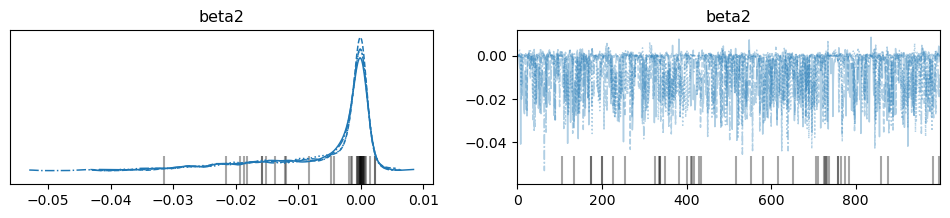

In [67]:
az.plot_trace(idata, var_names='beta2');